<h1 align="center">Stock market screening and analysis</h1> 

<font size="3">Written by Ibinabo Bestmann</font>

Stock markets tend to react very quickly to a variety of factors such as news, earnings reports, etc. While it may be prudent to develop trading strategies based on fundamental data, the rapid changes in the stock market are incredibly hard to predict and may not conform to the goals of more short term traders. This study aims to use data science as a means to both identify high potential stocks, as well as attempt to forecast future prices/price movement in an attempt to maximize an investor’s chances of success.

In the first half of this analysis, I will introduce a strategy to search for stocks that involves identifying the highest-ranked stocks based on trading volume during the trading day. I will also include information based on twitter and sentiment analysis in order to provide an idea of which stocks have the maximum probability of going up in the near future. The next half of the project will attempt to apply forecasting techniques to our chosen stock(s). I will apply deep learning via a **Long short term memory (LSTM) neural network**, which is a form of a recurrent neural network (RNN) to predict close prices. Finally, I will also demonstrate how **simple linear regression** could aid in forecasting. 

## Part 1: Stock screening

Let's begin by importing relevant packages

In [1]:
import yahoo_fin.stock_info as ya
from alpha_vantage.timeseries import TimeSeries
from alpha_vantage.techindicators import TechIndicators
from alpha_vantage.sectorperformance import SectorPerformances
import pandas as pd
import pandas_datareader as web
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import requests 
import numpy as np

We begin by scrape data on the most active stocks in a given time period, in this case one day. Higher trading volume is more likely to result in bigger price volatility which could potentially result in larger gains.  

In [2]:
movers = ya.get_day_most_active()
movers.head()

,Symbol,Name,Price (Intraday),Change,% Change,Volume,Avg Vol (3 month),Market Cap,PE Ratio (TTM)
0,CSCO,"Cisco Systems, Inc.",42.72,-5.38,-11.19,89447000.0,22215000.0,1.80377e+11,16.94
1,SRNE,"Sorrento Therapeutics, Inc.",13.01,0.60,4.83,80883000.0,52273000.0,3.149e+09,NaN
2,AMD,"Advanced Micro Devices, Inc.",81.84,-0.77,-0.93,57093000.0,64091000.0,9.6085e+10,159.22
3,BAC,Bank of America Corporation,26.35,-0.38,-1.42,54573000.0,73060000.0,2.28299e+11,12.68
4,GE,General Electric Company,6.60,-0.12,-1.79,51798000.0,99811000.0,5.7772e+10,NaN


Right away we notice that stocks with negative price changes are also included in our results. A filter to get only stocks with a positive % change is applied to get our desired stocks

In [3]:
movers = movers[movers['% Change'] >= 0]
movers.head()

,Symbol,Name,Price (Intraday),Change,% Change,Volume,Avg Vol (3 month),Market Cap,PE Ratio (TTM)
1,SRNE,"Sorrento Therapeutics, Inc.",13.01,0.60,4.83,80883000.0,52273000.0,3.149e+09,NaN
5,AAPL,Apple Inc.,460.04,8.00,1.77,50105000.0,36787000.0,1.967T1.967T1.967T1.967T1.967T1.967T1.967T1.96...,34.89
6,NIO,NIO Limited,13.36,0.00,0.00,49377000.0,118525000.0,1.5824e+10,NaN
11,PLUG,Plug Power Inc.,11.36,0.73,6.87,35324000.0,24319000.0,4.163e+09,NaN
12,PCG,PG&E Corporation,9.62,0.34,3.66,31023000.0,22652000.0,1.9105e+10,NaN


Excellent! We have successfully scraped the data using the yahoo_fin python module. it is often a good idea to see if those stocks are also generating attention, and what kind of attention it is to avoid getting into false rallies. We will scrap some sentiment data courtesty of [sentdex](http://www.sentdex.com/financial-analysis/). Sometimes sentiments may lag due to source e.g Newsarticle published an hour after event, so we will also utilize [tradefollowers](https://www.tradefollowers.com/strength/twitter_strongest.jsp?tf=1d) for their twitter sentiment data. We will process both lists independently and combine them. For both the sentdex and tradefollowers data we use a 30 day time period. Using a single day might be great for day trading but increases probability of jumping on false rallies. 

NOTE: Sentdex only has stocks which belong to the S&P 500

In [4]:
res = requests.get('http://www.sentdex.com/financial-analysis/?tf=30d')
soup = BeautifulSoup(res.text)
table = soup.find_all('tr')

In [5]:
stock = []
sentiment = []
mentions = []
sentiment_trend = []

for ticker in table:
    ticker_info = ticker.find_all('td')
    
    try:
        stock.append(ticker_info[0].get_text())
    except:
        stock.append(None)
    try:
        sentiment.append(ticker_info[3].get_text())
    except:
        sentiment.append(None)
    try:
        mentions.append(ticker_info[2].get_text())
    except:
        mentions.append(None)
    try:
        if (ticker_info[4].find('span',{"class":"glyphicon glyphicon-chevron-up"})):
            sentiment_trend.append('up')
        else:
            sentiment_trend.append('down')
    except:
        sentiment_trend.append(None)
        

company_info = pd.DataFrame(data={'Symbol': stock, 'Sentiment': sentiment, 'direction': sentiment_trend, 'Mentions':mentions})

company_info

,Symbol,Sentiment,direction,Mentions
0,None,None,None,None
1,SP500,very good,up,124814
2,NOK,very good,down,8996
3,SNE,good,down,1616
4,MAT,very good,up,1309
...,...,...,...,...
419,GCI,very good,up,215
420,ZMH,very good,down,215
421,BWA,very good,down,208
422,JDSU,very good,up,27


We then combine these results with our results from the biggest movers on a given day. This done using a left join of this data frame with the original movers data frame

In [7]:
top_stocks = movers.merge(company_info, on='Symbol', how='left')
top_stocks.drop(['Market Cap','PE Ratio (TTM)'], axis=1, inplace=True)
top_stocks

,Symbol,Name,Price (Intraday),Change,% Change,Volume,Avg Vol (3 month),Sentiment,direction,Mentions
0,SRNE,"Sorrento Therapeutics, Inc.",13.010,0.600,4.83,80883000.0,52273000.0,NaN,NaN,NaN
1,AAPL,Apple Inc.,460.040,8.000,1.77,50105000.0,36787000.0,good,down,315
2,NIO,NIO Limited,13.360,0.000,0.00,49377000.0,118525000.0,NaN,NaN,NaN
3,PLUG,Plug Power Inc.,11.360,0.730,6.87,35324000.0,24319000.0,NaN,NaN,NaN
4,PCG,PG&E Corporation,9.620,0.340,3.66,31023000.0,22652000.0,good,down,325
5,NKLA,Nikola Corporation,45.970,3.160,7.38,23682000.0,22461000.0,NaN,NaN,NaN
6,NCLH,Norwegian Cruise Line Holdings Ltd.,15.340,0.110,0.72,23591000.0,59927000.0,NaN,NaN,NaN
7,NOK,Nokia Corporation,5.060,0.010,0.20,21909000.0,33151000.0,very good,down,8996
8,AUY,Yamana Gold Inc.,5.980,0.200,3.46,21349000.0,19437000.0,NaN,NaN,NaN
9,TSLA,"Tesla, Inc.",1621.000,66.240,4.26,19974000.0,13162000.0,good,up,322


A couple of stocks pop up with both very good sentiments and an upwards trend in favourability. ZNGA, TWTR and AES for instance stood out as potentially good picks. Note, the mentions here refer to the number of times the stock was referenced according to the internal metrics used by [sentdex](sentdex.com). Let's attempt supplimenting this information with some data based on twitter. We get stocks that showed the strongest twitter sentiments with a time period of 1 month

In [8]:
res = requests.get("https://www.tradefollowers.com/strength/twitter_strongest.jsp?tf=1m")
soup = BeautifulSoup(res.text)

stock_twitter = soup.find_all('tr')

In [10]:
twit_stock = []
sector = []
twit_score = []

for stock in stock_twitter:
    try:
        score = stock.find_all("td",{"class": "datalistcolumn"})
        twit_stock.append(score[0].get_text().replace('$','').strip())
        sector.append(score[2].get_text().replace('\n','').strip())
        twit_score.append(score[4].get_text().replace('\n','').strip())
    except:
        twit_stock.append(np.nan)
        sector.append(np.nan)
        twit_score.append(np.nan)
        
twitter_df = pd.DataFrame({'Symbol': twit_stock, 'Sector': sector, 'Twit_Bull_score': twit_score})

# Remove NA values 
twitter_df.dropna(inplace=True)
twitter_df.drop_duplicates(subset ="Symbol", 
                     keep = 'first', inplace = True)
twitter_df.reset_index(drop=True,inplace=True)
twitter_df

,Symbol,Sector,Twit_Bull_score
0,AAPL,Technology,"6,004"
1,AMZN,Consumer Services,"4,063"
2,MSFT,Technology,"3,464"
3,AMD,Technology,"3,318"
4,FB,Technology,"2,682"
...,...,...,...
95,WLL,Energy,122
96,SNE,Consumer Durables,122
97,HL,Basic Industries,121
98,CMCSA,Consumer Services,119


Twit_Bull_score refers to the internally scoring used at [tradefollowers](tradefollowers.com) to rank stocks based on twitter sentiments, and can range from 1 to as high as 10,000 or greater. With the twitter sentiments obtains, we combine it with our sentiment data to get an overall idea of the data. 

In [11]:
Final_list =  top_stocks.merge(twitter_df, on='Symbol', how='left')
Final_list

,Symbol,Name,Price (Intraday),Change,% Change,Volume,Avg Vol (3 month),Sentiment,direction,Mentions,Sector,Twit_Bull_score
0,SRNE,"Sorrento Therapeutics, Inc.",13.010,0.600,4.83,80883000.0,52273000.0,NaN,NaN,NaN,NaN,NaN
1,AAPL,Apple Inc.,460.040,8.000,1.77,50105000.0,36787000.0,good,down,315,Technology,"6,004"
2,NIO,NIO Limited,13.360,0.000,0.00,49377000.0,118525000.0,NaN,NaN,NaN,NaN,NaN
3,PLUG,Plug Power Inc.,11.360,0.730,6.87,35324000.0,24319000.0,NaN,NaN,NaN,Capital Goods,554
4,PCG,PG&E Corporation,9.620,0.340,3.66,31023000.0,22652000.0,good,down,325,NaN,NaN
5,NKLA,Nikola Corporation,45.970,3.160,7.38,23682000.0,22461000.0,NaN,NaN,NaN,NaN,NaN
6,NCLH,Norwegian Cruise Line Holdings Ltd.,15.340,0.110,0.72,23591000.0,59927000.0,NaN,NaN,NaN,NaN,NaN
7,NOK,Nokia Corporation,5.060,0.010,0.20,21909000.0,33151000.0,very good,down,8996,Technology,379
8,AUY,Yamana Gold Inc.,5.980,0.200,3.46,21349000.0,19437000.0,NaN,NaN,NaN,Basic Industries,248
9,TSLA,"Tesla, Inc.",1621.000,66.240,4.26,19974000.0,13162000.0,good,up,322,NaN,NaN


Finally, we include a twitter momentum score.

In [12]:
res2 = requests.get("https://www.tradefollowers.com/active/twitter_active.jsp?tf=1m")
soup2 = BeautifulSoup(res2.text)

stock_twitter2 = soup2.find_all('tr')

In [13]:
twit_stock2 = []
sector2 = []
twit_score2 = []

for stock in stock_twitter2:
    try:
        score2 = stock.find_all("td",{"class": "datalistcolumn"})
        
         
        
        twit_stock2.append(score2[0].get_text().replace('$','').strip())
        sector2.append(score2[2].get_text().replace('\n','').strip())
        twit_score2.append(score2[4].get_text().replace('\n','').strip())
    except:
        twit_stock2.append(np.nan)
        sector2.append(np.nan)
        twit_score2.append(np.nan)
        
twitter_df2 = pd.DataFrame({'Symbol': twit_stock2, 'Sector': sector2, 'Twit_mom': twit_score2})

# Remove NA values 
twitter_df2.dropna(inplace=True)
twitter_df2.drop_duplicates(subset ="Symbol", 
                     keep = 'first', inplace = True)
twitter_df2.reset_index(drop=True,inplace=True)
twitter_df2

,Symbol,Sector,Twit_mom
0,TSLA,Capital Goods,"27,183"
1,AAPL,Technology,"14,100"
2,AMZN,Consumer Services,"10,454"
3,MSFT,Technology,"8,252"
4,AMD,Technology,"7,057"
...,...,...,...
95,LMT,Consumer Services,421
96,VZ,Public Utilities,420
97,AUY,Basic Industries,419
98,UNH,Health Care,400


We again combine the dataframes to earlier concatanated dataframes. This will form our recommender list

In [15]:
Recommender_list = Final_list.merge(twitter_df2, on='Symbol', how='left')
Recommender_list.drop(['Volume','Avg Vol (3 month)'],axis=1, inplace=True)
Recommender_list

,Symbol,Name,Price (Intraday),Change,% Change,Sentiment,direction,Mentions,Sector_x,Twit_Bull_score,Sector_y,Twit_mom
0,SRNE,"Sorrento Therapeutics, Inc.",13.010,0.600,4.83,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AAPL,Apple Inc.,460.040,8.000,1.77,good,down,315,Technology,"6,004",Technology,"14,100"
2,NIO,NIO Limited,13.360,0.000,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,PLUG,Plug Power Inc.,11.360,0.730,6.87,NaN,NaN,NaN,Capital Goods,554,Capital Goods,"1,187"
4,PCG,PG&E Corporation,9.620,0.340,3.66,good,down,325,NaN,NaN,NaN,NaN
5,NKLA,Nikola Corporation,45.970,3.160,7.38,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NCLH,Norwegian Cruise Line Holdings Ltd.,15.340,0.110,0.72,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NOK,Nokia Corporation,5.060,0.010,0.20,very good,down,8996,Technology,379,Technology,624
8,AUY,Yamana Gold Inc.,5.980,0.200,3.46,NaN,NaN,NaN,Basic Industries,248,Basic Industries,419
9,TSLA,"Tesla, Inc.",1621.000,66.240,4.26,good,up,322,NaN,NaN,Capital Goods,"27,183"


Our list now contains even more informationt to help us with our trades. Stocks which it suggests might generate positive returns include TSLA, ZNGA and TWTR. There is also the posibility that we do not get a stock that falls in all our generated lists, so usage of, for instance, the price information and the twitter data could still give us a good idea of what to expect in terms of performance. As an added measure, we can also obtain information on the sectors to see how they've performed. Again, we will use a one month time period for comparison. The aforementioned stocks belong to the Technology and consumer staples sectors.

{'Information': 'US Sector Performance (realtime & historical)', 'Last Refreshed': '2020-08-13 17:52:48 US/Eastern'}


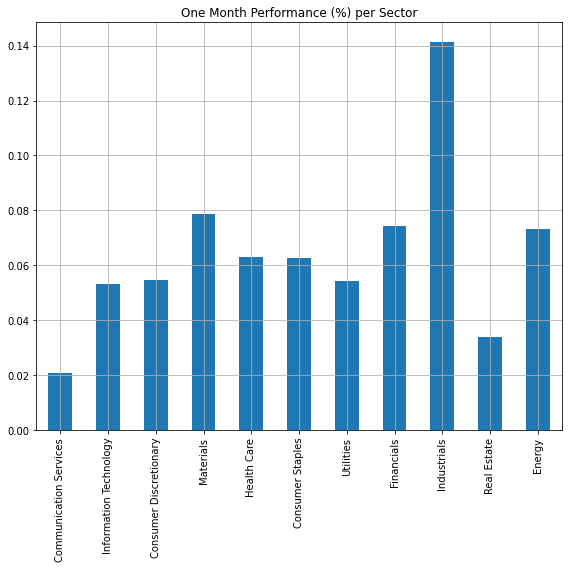

In [16]:
sp = SectorPerformances(key='0E66O7ZP6W7A1LC9', output_format='pandas')
plt.figure(figsize=(8,8))
data, meta_data = sp.get_sector()
print(meta_data)
data['Rank D: Month Performance'].plot(kind='bar')
plt.title('One Month Performance (%) per Sector')
plt.tight_layout()
plt.grid()
plt.show()

The industrials sector appears to be the best performing in this time period. Consumer staples appears to be doing better than IT, but overall they are up which bodes well for potential investors. Please note that this analysis is only a guide to find potentially positive return generating stocks. It is still up to the investor to do the research. 

## Part 2: Forecasting using an LSTM

In this section, we will atetmpt to apply deep learning to a stock of our chosing to predict future prices. At the time this project was conceived, the stock AMD was selected as it experienced really high gains at the time.

First we obtain stock data for our chosen stock. Data from 2014 data up till August of 2020 was obtained for our analysis. Our data will be obtained from yahoo

In [17]:
from datetime import datetime

In [18]:
start = datetime(2014,12,31)
end = datetime(2020,8,3)

In [19]:
stock_dt = web.DataReader('AMD','yahoo',start,end)
stock_dt.reset_index(inplace=True)
stock_dt.head()

,Date,High,Low,Open,Close,Volume,Adj Close
0,2014-12-31,2.70,2.64,2.64,2.67,11177900,2.67
1,2015-01-02,2.67,2.67,2.67,2.67,0,2.67
2,2015-01-05,2.70,2.64,2.67,2.66,8878200,2.66
3,2015-01-06,2.66,2.55,2.65,2.63,13912500,2.63
4,2015-01-07,2.65,2.54,2.63,2.58,12377600,2.58


In [20]:
stock_dt.tail()

,Date,High,Low,Open,Close,Volume,Adj Close
1402,2020-07-28,69.800003,67.019997,68.099998,67.610001,94181400,67.610001
1403,2020-07-29,77.190002,73.900002,75.500000,76.089996,132969700,76.089996
1404,2020-07-30,78.959999,75.070000,75.370003,78.199997,80286900,78.199997
1405,2020-07-31,78.959999,75.360001,78.669998,77.430000,71699700,77.430000
1406,2020-08-03,78.500000,77.059998,78.190002,77.669998,42628800,77.669998


### Feature selection/engineering

We add additional data that might potentially increase prediction accuracy. Here we use technical indicators.

In [21]:
# Technical Indicators 

# RSI
t_rsi = TechIndicators(key='0E66O7ZP6W7A1LC9',output_format='pandas')
data_rsi, meta_data_rsi = t_rsi.get_rsi(symbol='AMD', interval='daily',time_period = 9,
                          series_type='open')

# SMA 
t_sma = TechIndicators(key='0E66O7ZP6W7A1LC9',output_format='pandas')
data_sma, meta_data_sma = t_sma.get_sma(symbol='AMD', interval='daily',time_period = 9,
                          series_type='open')

#EMA
t_ema = TechIndicators(key='0E66O7ZP6W7A1LC9',output_format='pandas')
data_ema, meta_data_ema = t_ema.get_ema(symbol='AMD', interval='daily',time_period = 9,
                          series_type='open')


In [22]:
#On Balance volume
t_obv = TechIndicators(key='0E66O7ZP6W7A1LC9',output_format='pandas')
data_obv, meta_data_obv = t_obv.get_obv(symbol='AMD', interval='daily')
 
# Bollinger bands
t_bbands = TechIndicators(key='0E66O7ZP6W7A1LC9',output_format='pandas')
data_bbands, meta_data_bb = t_bbands.get_bbands(symbol='AMD', interval='daily', series_type='open', time_period=9)

To learn more about technical indicators and how they are useful in stock analysis, I welcome you to explore [investopedia](https://www.investopedia.com/). Let's combine these indicators into a dataframe

In [23]:
t_ind = pd.concat([data_ema, data_sma, data_rsi, data_obv, data_bbands],axis=1)
t_ind

,EMA,SMA,RSI,OBV,Real Middle Band,Real Lower Band,Real Upper Band
date,,,,,,,
1999-11-01,NaN,NaN,NaN,1.563700e+06,NaN,NaN,NaN
1999-11-02,NaN,NaN,NaN,3.461800e+06,NaN,NaN,NaN
1999-11-03,NaN,NaN,NaN,5.697800e+06,NaN,NaN,NaN
1999-11-04,NaN,NaN,NaN,3.282800e+06,NaN,NaN,NaN
1999-11-05,NaN,NaN,NaN,5.430800e+06,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2020-08-07,78.9660,78.9978,90.0053,5.235094e+09,78.9978,67.7943,90.2012
2020-08-10,80.1828,80.8811,82.3273,5.164558e+09,80.8811,72.2309,89.5313
2020-08-11,80.2882,81.4600,65.4897,5.086680e+09,81.4600,73.6735,89.2465


We then extract the values for the time interval of choice

In [24]:
t_ind = t_ind.loc[start:end].reset_index()

Now we combine them with our original dataframe containing price and volume information

In [201]:
df_updated = pd.concat([stock_dt,t_ind],axis=1)
df_updated.set_index('Date',drop=True,inplace=True)
df_updated

,High,Low,Open,Close,Volume,Adj Close,date,EMA,SMA,RSI,OBV,Real Middle Band,Real Lower Band,Real Upper Band
Date,,,,,,,,,,,,,,
2014-12-31,2.700000,2.640000,2.640000,2.670000,11177900,2.670000,2014-12-31,2.6192,2.6167,53.2246,-4.168259e+08,2.6167,2.5187,2.7146
2015-01-02,2.670000,2.670000,2.670000,2.670000,0,2.670000,2015-01-02,2.6353,2.6300,60.2336,-4.084956e+08,2.6300,2.5233,2.7367
2015-01-05,2.700000,2.640000,2.670000,2.660000,8878200,2.660000,2015-01-05,2.6423,2.6456,55.5514,-4.173738e+08,2.6456,2.5638,2.7273
2015-01-06,2.660000,2.550000,2.650000,2.630000,13912500,2.630000,2015-01-06,2.6438,2.6567,52.4911,-4.312904e+08,2.6567,2.6105,2.7029
2015-01-07,2.650000,2.540000,2.630000,2.580000,12377600,2.580000,2015-01-07,2.6411,2.6500,49.4278,-4.436680e+08,2.6500,2.6078,2.6922
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-07-28,69.800003,67.019997,68.099998,67.610001,94181400,67.610001,2020-07-28,62.0433,60.3656,78.4792,4.842076e+09,60.3656,49.6763,71.0549
2020-07-29,77.190002,73.900002,75.500000,76.089996,132969700,76.089996,2020-07-29,64.7346,62.6789,85.3875,4.975046e+09,62.6789,49.2517,76.1061
2020-07-30,78.959999,75.070000,75.370003,78.199997,80286900,78.199997,2020-07-30,66.8617,64.9078,84.8492,5.055333e+09,64.9078,50.4902,79.3254


Before we begin, it is often a good idea to visually inspect the stock data to have an idea of the price trend and volume information

In [202]:
import mplfinance as mpf

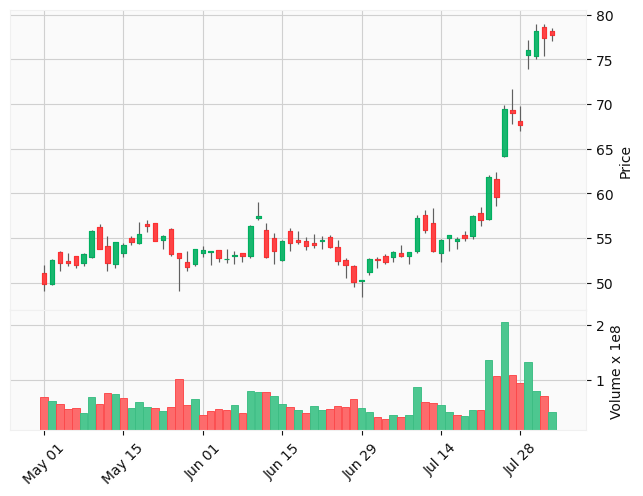

In [203]:
mpf.plot(df_updated.loc[datetime(2020,5,1):datetime(2020,8,11)],type='candle',style='yahoo',figsize=(8,6),volume=True)

in the month of July, AMD experienced a massive price surge. Let's have a look at the data with the indicators included

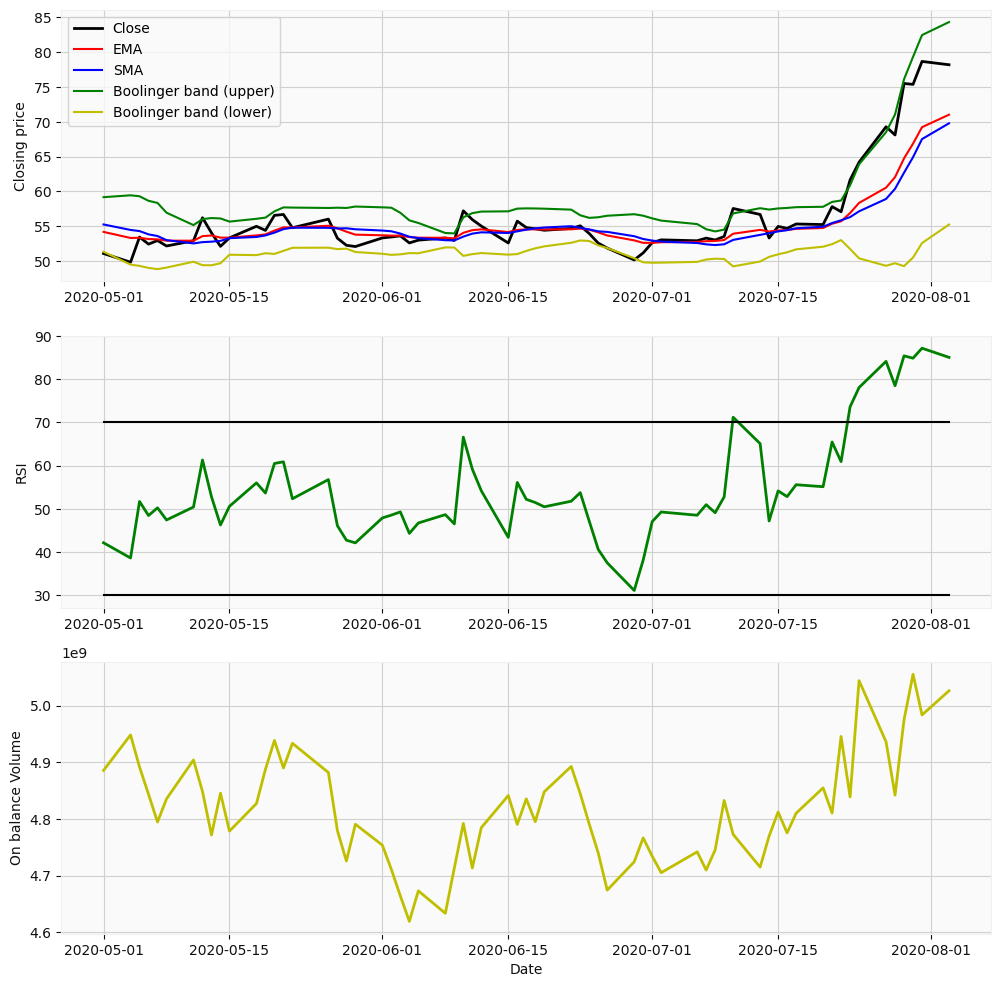

In [204]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(12,12))

ax[0].plot(df_updated['Open'].loc[datetime(2020,5,1):datetime(2020,8,11)],'k',lw=2,label='Close')
ax[0].plot(df_updated['EMA'].loc[datetime(2020,5,1):datetime(2020,8,11)],'r',lw=1.5,label='EMA')
ax[0].plot(df_updated['SMA'].loc[datetime(2020,5,1):datetime(2020,8,11)],'b',lw=1.5,label='SMA')
ax[0].plot(df_updated['Real Upper Band'].loc[datetime(2020,5,1):datetime(2020,8,11)],'g',lw=1.5,label='Boolinger band (upper)')
ax[0].plot(df_updated['Real Lower Band'].loc[datetime(2020,5,1):datetime(2020,8,11)],'y',lw=1.5,label='Boolinger band (lower)')
ax[0].set_ylabel('Closing price')


ax[0].legend()


temp = len(df_updated['RSI'].loc[datetime(2020,5,1):datetime(2020,8,11)])

ax[1].plot(df_updated['RSI'].loc[datetime(2020,5,1):datetime(2020,8,11)],'g',lw=2,label='RSI')
ax[1].plot(df_updated['RSI'].loc[datetime(2020,5,1):datetime(2020,8,11)].index,70*np.ones((temp,1)).flatten(),'k')
ax[1].plot(df_updated['RSI'].loc[datetime(2020,5,1):datetime(2020,8,11)].index,30*np.ones((temp,1)).flatten(),'k')
ax[1].set_ylabel('RSI')
#ax[1].legend()

ax[2].plot(df_updated['OBV'].loc[datetime(2020,5,1):datetime(2020,8,11)],'y',lw=2,label='OBV')
ax[2].set_ylabel('On balance Volume')
#ax[2].legend()
ax[2].set_xlabel('Date');


Indicators give us an idea of the direction of future prices. For instance, the Exponential moving average (EMA) crossing the Simple moving average (SMA) might indicate a positive uptrend in price. RSI gives us an idea of how much the stock is being bought or sold. An RSI of 70 for instance might indicate an overbought stock, and tells us the price is very likely to go down in the future, while an RSI of 30 indicates an oversold stock and could potentially be a good buy point for a stock. On balance volume gives us the relative changes in volume, and can potentially identify true rallies or breakouts. Bollinger bands provide an idea of the volatility of the stock.

We also want to take into account relative changes between trading days as they tend to be less volatile, and therefore a bit more stationary. We will take the difference between two consecutive days in this case. 

In [39]:
df_updated['Diff_Open'] = df_updated['Open'] - df_updated['Open'].shift(1)
df_updated['Diff_Close'] = df_updated['Close'] - df_updated['Close'].shift(1)
df_updated['Diff-Volume']  = df_updated['Volume'] - df_updated['Volume'].shift(1)
df_updated['Diff-High']  = df_updated['High'] - df_updated['High'].shift(1)
df_updated['Diff-Low']  = df_updated['Low'] - df_updated['Low'].shift(1)
df_updated['Diff-Close (forward)'] = np.where(df_updated['Close'].shift(-1) > df_updated['Close'],1,-1)


df_updated['High-Low'] = df_updated['High'] - df_updated['Low'].shift(1)
df_updated['Open-Close'] = df_updated['Open'] - df_updated['Close'].shift(1)

df_updated['Returns'] = df_updated['Open'].pct_change(1)


In [40]:
df_updated.head()

,High,Low,Open,Close,Volume,Adj Close,date,EMA,SMA,RSI,...,Real Upper Band,Diff_Open,Diff_Close,Diff-Volume,Diff-High,Diff-Low,Diff-Close (forward),High-Low,Open-Close,Returns
Date,,,,,,,,,,,,,,,,,,,,,
2014-12-31,2.70,2.64,2.64,2.67,11177900,2.67,2014-12-31,2.6192,2.6167,53.2246,...,2.7146,NaN,NaN,NaN,NaN,NaN,-1,NaN,NaN,NaN
2015-01-02,2.67,2.67,2.67,2.67,0,2.67,2015-01-02,2.6353,2.6300,60.2336,...,2.7367,0.03,0.00,-11177900.0,-0.03,0.03,-1,0.03,0.00,0.011364
2015-01-05,2.70,2.64,2.67,2.66,8878200,2.66,2015-01-05,2.6423,2.6456,55.5514,...,2.7273,0.00,-0.01,8878200.0,0.03,-0.03,-1,0.03,0.00,0.000000
2015-01-06,2.66,2.55,2.65,2.63,13912500,2.63,2015-01-06,2.6438,2.6567,52.4911,...,2.7029,-0.02,-0.03,5034300.0,-0.04,-0.09,-1,0.02,-0.01,-0.007491
2015-01-07,2.65,2.54,2.63,2.58,12377600,2.58,2015-01-07,2.6411,2.6500,49.4278,...,2.6922,-0.02,-0.05,-1534900.0,-0.01,-0.01,1,0.10,0.00,-0.007547


The next step is to visualize how the features relate to each other. We employ a correlation matrix for this purpose

In [41]:
df_updated.drop(['date','Real Middle Band','Adj Close'],axis=1,inplace=True)

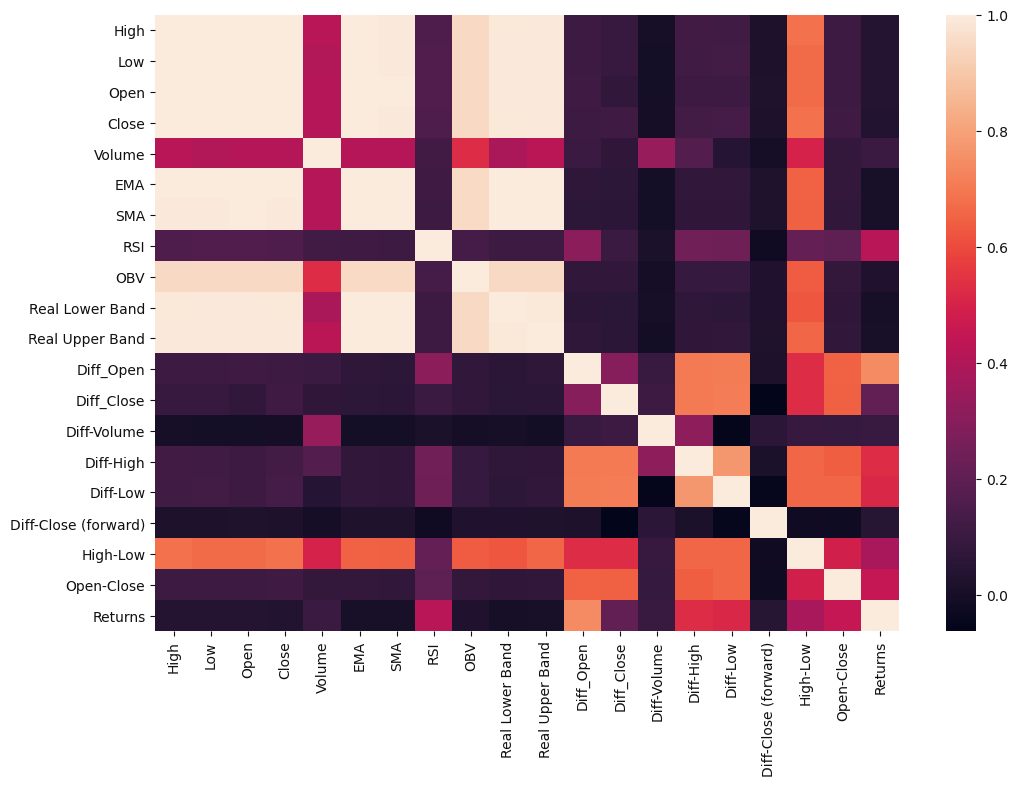

In [194]:
import seaborn as sns
plt.figure(figsize=(12,8))
sns.heatmap(df_updated.corr());

The closing price has very strong correlations with some of the other price informations such as opening price, highs and lows. 
On the other hands, the differential prices arn't as correlated. We want to limit the amount of colinearity in our system before running any machine learning routine. So feature selection is a must.

### Feature Selection

We utilize two means of feature selection in this section. Random forests and mutual information gain. Random forests are
very popular due to their relatively good accuracy, robustness as well as simplicity in terms of utilization. They can directly measure the impact of each feature on accuracy of the model and in essence give them a rank. Information gain on the other hand, calculates the reduction in entropy from transforming a dataset in some way. Mutual information gain essentially evaluates the gain of each variable in the context of the target variable. 

In [44]:
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler

### Random forest regressor

In [45]:
# Seperate the target variable from the features
y = df_updated['Close'].iloc[1:].dropna()
X = df_updated.drop(['Close'],axis=1).iloc[1:].dropna()

In [53]:
X_train, X_test,y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=0)

In [54]:
X_train.shape, y_train.shape

((1124, 19), (1124,))

In [55]:
feat = SelectFromModel(RandomForestRegressor(n_estimators=100,random_state=0,n_jobs=-1))
feat.fit(X_train,y_train)
feat.get_support()

array([ True,  True,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False])

In [56]:
X_train.columns[feat.get_support()]

Index(['High', 'Low', 'Open'], dtype='object')

The regressor essentially selected the features that displayed good correlation with the Close price. However, although it selected the most important we would like information on the information gain from each variable. An issue with using random forests is it tends to diminsh the importance of other correlated variables and may lead to incorrect interpretation. However, it does help reduce overfitting

### Mutual information gain

In [57]:
from sklearn.feature_selection import mutual_info_regression, SelectKBest

In [58]:
mi = mutual_info_regression(X_train,y_train)
mi = pd.Series(mi)
mi.index = X_train.columns
mi.sort_values(ascending=False,inplace=True)

In [59]:
mi

Low                     3.708476
High                    3.706451
Open                    3.165398
EMA                     2.671979
Real Upper Band         2.600057
SMA                     2.553970
OBV                     2.549028
Real Lower Band         2.498755
Volume                  0.586351
High-Low                0.546105
Diff-Low                0.395561
Open-Close              0.381547
Diff_Open               0.362054
Diff-High               0.352471
Diff_Close              0.324437
RSI                     0.208567
Diff-Volume             0.111994
Returns                 0.104227
Diff-Close (forward)    0.015581
dtype: float64

The results validate the results using the random forest regressor, but it appears some of the other variables also contribute 
a decent amount of information. We will select values greater than 2 for our analysis.

In [60]:
sel = SelectKBest(mutual_info_regression, k = 8).fit(X_train, y_train) #
Features = X_train.columns[sel.get_support()]
Features.values

array(['High', 'Low', 'Open', 'EMA', 'SMA', 'OBV', 'Real Lower Band',
       'Real Upper Band'], dtype=object)

### Preprocessing

In order to construct a Long short term memory neural network (LSTM), we need to understand its structure. Below is the design of a typical LSTM unit.  Data source: [Researchgate](https://www.researchgate.net/publication/334268507_Application_of_Long_Short-Term_Memory_LSTM_Neural_Network_for_Flood_Forecasting)

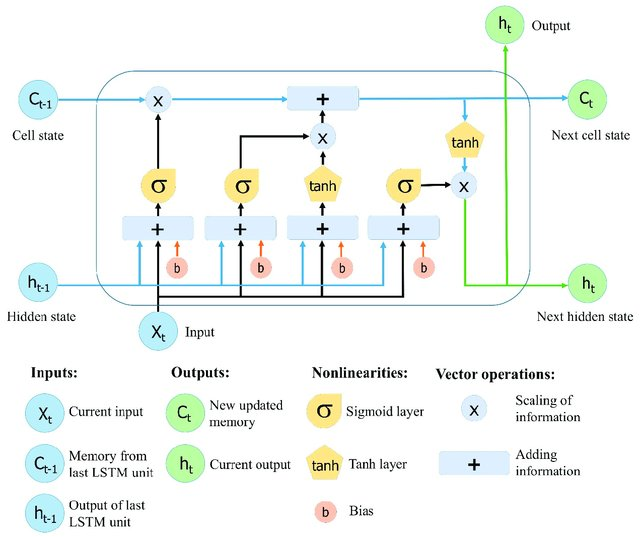

As mentioned earlier, LSTM's are a special type of Recurrent neural networks (RNN). Recurrent neural networks (RNN) are a special type of neural network in which the output of a layer is fed back to the input layer multiple times in order to learn from the past data. Basically, the neural network is trying to learn data that follows a sequence. However, since the RNNs utilize past data, they can become computationally expensive due to storing large amouts of data in memory. The LSTM mitigates this issue, using gates. It has a cell state, and 3 gates; forget, imput and output gates. 

The cell state is essentially the memory of the network. It carries information throughtout the data sequence processing. Information is added or removed from this cell state using gates. Information from the previous hidden state and current input are combined and passed through a sigmoid function at the forget gate. The sigmoid function determines which data to keep or forget. The transformed values are then multipled by the current cell state.

Next, the information from the previous hidden state combined with the input is passed through a sigmoid function to again determine important information, and also a tanh function to transform data between -1 and 1. This transformation helps with the stability of the network and helps deal with the vanishing/exploding gradient problem. These 2 outputs are multiplied together, and the output is added to the current cell state with the sigmoid function applied to it to give us our new cell state for the next time step.

Finally, the information from the hidden state combined with the current input are combined and a sigmoid function applied to it. The new cell state is passed through a tanh function to transform the values and both outputs are multiplied to determine the new hidden state for the next time step. 

Now we have an idea of how the LSTM works, let's construct one. First we split our data into training and test set

In [65]:
df_updated.reset_index(drop=True,inplace=True)

train_size = int(len(df_updated) * 0.8)
test_size =  len(df_updated) - train_size

# Make sure to omit the first row, contains NAN's
train = df_updated.iloc[1:train_size]
test = df_updated.iloc[train_size:]

In [66]:
train.shape, test.shape

((1124, 20), (282, 20))

In [67]:
# Extract the features
total_features = list(Features.values)

total_features.append('Close')
total_features


train = train[total_features]
test = test[total_features]

train.shape,test.shape

((1124, 9), (282, 9))

Before we proceed, it is important to scale the data. Scaling is done to ensure one set of features don't have more importance relative to the others. In addition, having values between 0 and 1 will help the neural network converge faster if at all it does. We apply different scalings to the test and training data to avoid leakage into our model. 

In [68]:
# Scale both features and target variables

f_transformer = MinMaxScaler() # Feature scaler
targ_transformer = MinMaxScaler() # Target scaler


f_transformer = f_transformer.fit(train[Features].to_numpy())
targ_transformer = targ_transformer.fit(train[['Close']])

train.loc[:,Features] = f_transformer.transform(train[Features].to_numpy())
train['Close'] = targ_transformer.transform(train[['Close']].to_numpy())

test.loc[:,Features] = f_transformer.transform(test[Features].to_numpy())
test['Close'] = targ_transformer.transform(test[['Close']].to_numpy())


In [69]:
train.shape, test.shape

((1124, 9), (282, 9))

The figure below shows how the sequential data for an LSTM is constructed to be fed into the network. Data source: [Althelaya et al, 2018](https://ieeexplore.ieee.org/document/8355458)

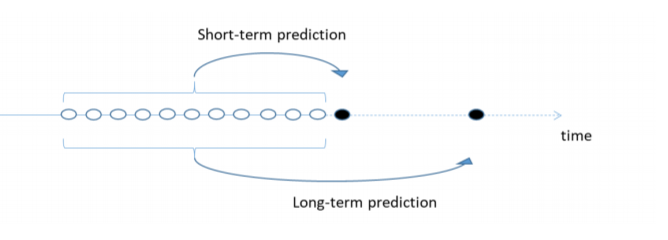

Bassically for data at time t, with a window size of N, the target feature will be the data point at time t, and the feature will be the data points [t-1, t-N]. We then sequentially move forward in time using this approach. We therefore need to format our data that way.

In [70]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [71]:
time_steps = 10

X_train_lstm, y_train_lstm = create_dataset(train.drop(['Close'],axis=1), train['Close'], time_steps)
X_test_lstm, y_test_lstm = create_dataset(test.drop(['Close'],axis=1), test['Close'], time_steps)

In [72]:
X_train_lstm.shape, y_train_lstm.shape

((1114, 10, 8), (1114,))

In [73]:
X_test_lstm.shape, y_test_lstm.shape

((272, 10, 8), (272,))

### Building LSTM model

The new installment of tensorflow (Tensorflow 2.0) via keras has made implmentation of deep learning models much easier than in previous installments. We will apply a bidrectional LSTM as they have been shown to more effective in certain applications (see [Althelaya et al, 2018](https://ieeexplore.ieee.org/document/8355458)). This due to the fact that the network learns using both past and future data in 2 layers. Each layer performs the operations using reversed time steps to each other. The loss function in this case will be the mean squared error, and the adam optimizer with the default learning rate is applied. 

In [82]:
from tensorflow import keras

In [83]:
model = keras.Sequential()
model.add(keras.layers.Bidirectional(
        keras.layers.LSTM(
          units=32, 
          input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]))
  )
)

model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(units=1))


In [84]:
model.compile(optimizer='adam',loss='mean_squared_error')

In [85]:
history = model.fit(
    X_train_lstm, y_train_lstm, 
    epochs=90, 
    batch_size=40, 
    validation_split=0.2,
    shuffle=False,
    verbose=1   
)

Epoch 1/90

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

23/23 [==============================] - 1s 45ms/step - loss: 0.0062 - val_loss: 0.0806
Epoch 2/90
23/23 [==============================] - 0s 7ms/step - loss: 0.0032 - val_loss: 0.0212
Epoch 3/90
23/23 [==============================] - 0s 7ms/step - loss: 0.0028 - val_loss: 0.0261
Epoch 4/90
23/23 [==============================] - 0s 6ms/step - loss: 0.0030 - val_loss: 0.0128
Epoch 5/90
23/23 [==============================] - 0s 6ms/step - loss: 0.0028 - val_loss: 0.0067
Epoch 6/90
23/23 

In [87]:
test_loss = model.evaluate(X_test_lstm,y_test_lstm)

9/9 [==============================] - 0s 2ms/step - loss: 0.0374


In [88]:
def plot_learningCurve(history,epoch_num):  
  
    epoch_range = range(1,epoch_num+1)

    plt.plot(epoch_range,history.history['loss'])
    plt.plot(epoch_range,history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train','val'], loc='upper left')
    plt.show()
 

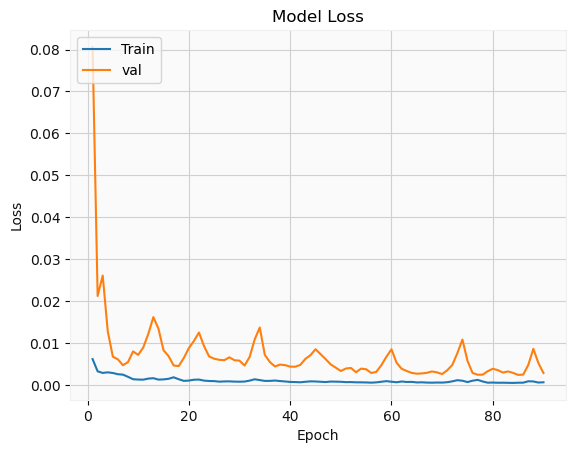

In [90]:
plot_learningCurve(history,90)

With each epoch, the validation loss is decreasing but in a bit of a stochastic manner. The training loss is fairly consisten throughout. There maybe some overfitting in there but you can always tune model parameters and explore data more. Let's make some predictions on the test data just to see what's happening

In [91]:
y_pred = model.predict(X_test_lstm)

We need to apply some inverse scaling to get back our original results.

In [92]:
y_train_inv = targ_transformer.inverse_transform(y_train_lstm.reshape(1, -1))
y_test_inv = targ_transformer.inverse_transform(y_test_lstm.reshape(1, -1))
y_pred_inv = targ_transformer.inverse_transform(y_pred)

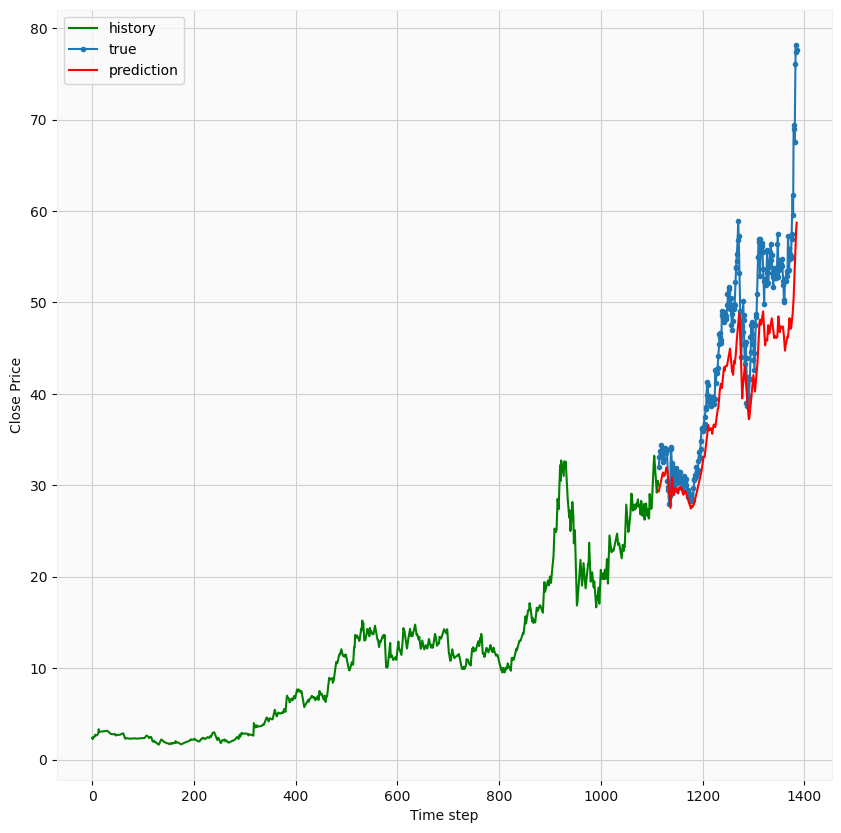

In [193]:
plt.figure(figsize=(10,10))
plt.plot(np.arange(0, len(y_train_lstm)), y_train_inv.flatten(), 'g', label="history")
plt.plot(np.arange(len(y_train_lstm,), len(y_train_lstm) + len(y_test_lstm)), y_test_inv.flatten(), marker='.', label="true")
plt.plot(np.arange(len(y_train_lstm), len(y_train_lstm) + len(y_test_lstm)), y_pred_inv.flatten(), 'r', label="prediction")
plt.ylabel('Close Price')
plt.xlabel('Time step')
plt.legend()
plt.show();

At first glance we can see that the our predictions are not very great, we could define adjust our model parameters some more. However, they appear to be following the trends pretty well. Let's take a closer look

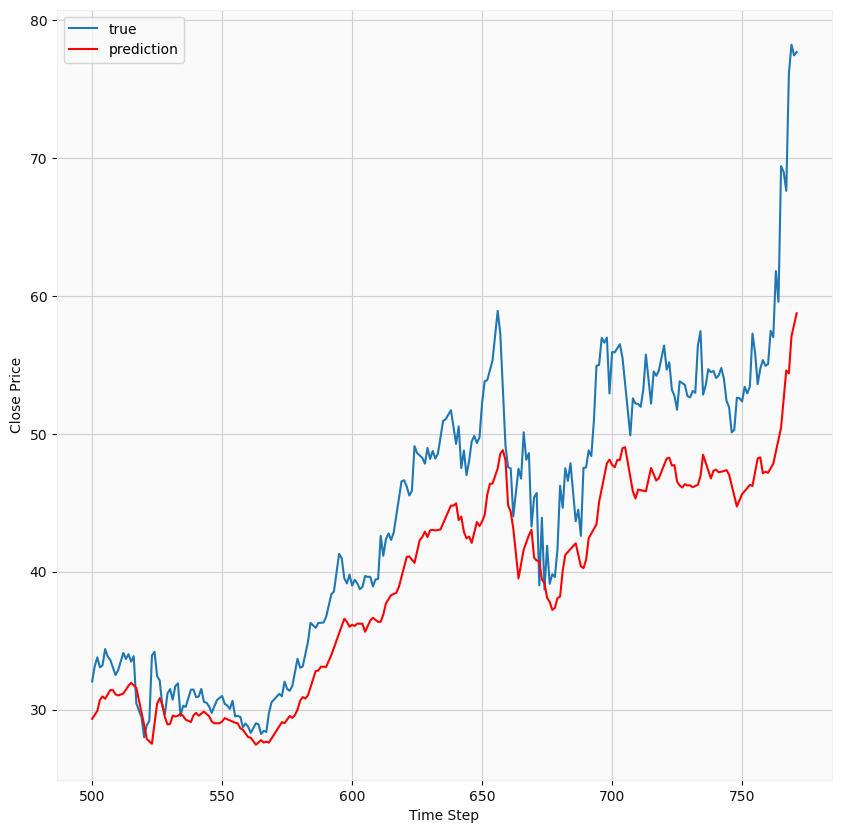

In [192]:
plt.figure(figsize=(10,10))
plt.plot(np.arange(len(y_train_lstm[0:500],), len(y_train_lstm[0:500]) + len(y_test_lstm[0:500])), y_test_inv.flatten()[0:500],  label="true")
plt.plot(np.arange(len(y_train_lstm[0:500]), len(y_train_lstm[0:500]) + len(y_test_lstm[0:500])), y_pred_inv.flatten()[0:500], 'r', label="prediction")
plt.ylabel('Close Price')
plt.xlabel('Time Step')
plt.legend()
plt.show();

Now it will become apparent why I did not use a large amount of epochs to train my model. At first glance, we notice the LSTM has some implicit autocorrelation in its results since its predictions for a given day are very similar to those of the previous day. It essentially lags. Its basically showing that the best guess of the model is very similar to previous results. This should not be a surprising result; The stock market is influenced by a number of factors such as news, earnings reports, meargers etc. Therefore, it is a bit too choatic and stoachastic to be acurately modelled because it depends on so many factors, some of which can be sporadic i.e positive or negative news. Therefore in my opinion, this may not be the best way to predict stock prices. Of course with major advances in AI there might actually be a way, but I don't think the hedge funds will be sharing their methods anytime soon.

## Part 3: Regression analysis

Of course we could still make an attempt to have an idea of what the possible price movements might be. In this case I will utilize the differential prices as there's less volatility compared to using absolute prices. Let's explore these relationships

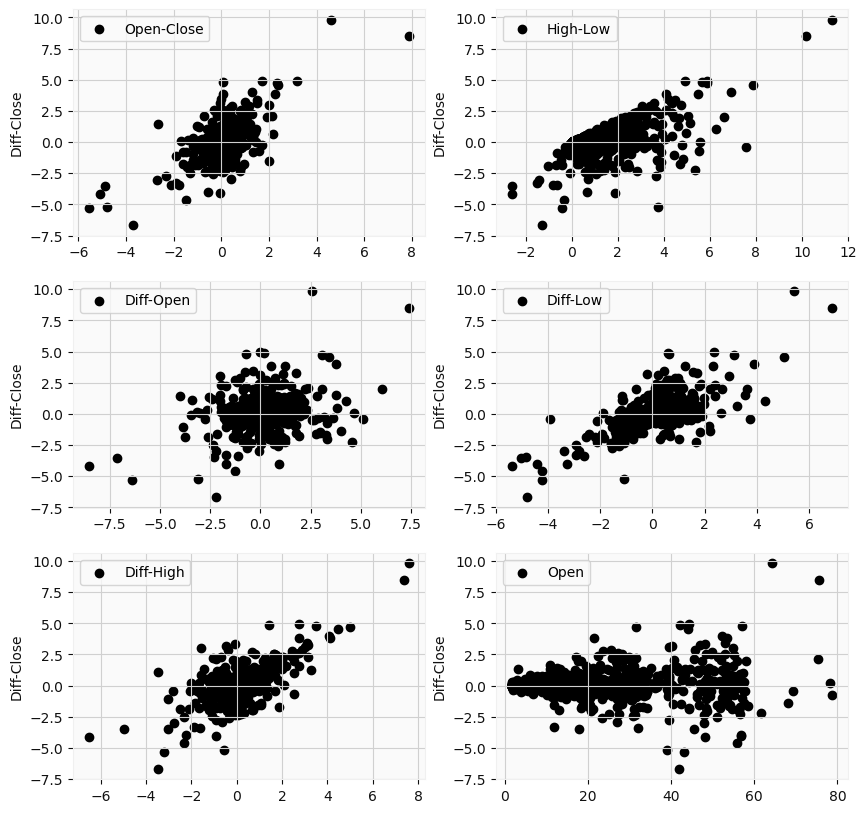

In [191]:
fig, ax = plt.subplots(nrows=3,ncols=2,figsize=(10,10))

ax[0,0].scatter(df_updated['Open-Close'],df_updated['Diff_Close'],c='k')
ax[0,0].legend(['Open-Close'])
ax[0,0].set_ylabel('Diff-Close')

ax[0,1].scatter(df_updated['High-Low'],df_updated['Diff_Close'],c='k')
ax[0,1].legend(['High-Low'])
ax[0,1].set_ylabel('Diff-Close')

ax[1,0].scatter(df_updated['Diff_Open'],df_updated['Diff_Close'],c='k')
ax[1,0].legend(['Diff-Open'])
ax[1,0].set_ylabel('Diff-Close')

ax[1,1].scatter(df_updated['Diff-Low'],df_updated['Diff_Close'],c='k')
ax[1,1].legend(['Diff-Low'])
ax[1,1].set_ylabel('Diff-Close')

ax[2,0].scatter(df_updated['Diff-High'],df_updated['Diff_Close'],c='k')
ax[2,0].legend(['Diff-High'])
ax[2,0].set_ylabel('Diff-Close')

ax[2,1].scatter(df_updated['Open'],df_updated['Diff_Close'],c='k')
ax[2,1].legend(['Open'])
ax[2,1].set_ylabel('Diff-Close');

Above are a series of plots that show the relationship between different differential price measurements and the differential close. In this study, the differece relates to the difference between a value at time t and the previous day value at time t-1. The Differential high, differential low, differential high-low and differential open-close appear to have a linear relationship with the differential close. However, only the differential open-close would be useful in an analysis. This because on a given day (time t), we can not know what the highs or lows are before hand till the day ends. However, we know the open value at the start of the trading period. 

Let's separate the data features and target variables. We will use Ridge regression in this case to make our model more generalizable

In [105]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import GridSearchCV, cross_val_score
import sklearn
from sklearn.metrics import median_absolute_error, mean_squared_error

In [110]:
X_reg = df_updated[['Open-Close']]
y_reg = df_updated['Diff_Close']

In [111]:
X_reg = X_reg.loc[1:,:]
y_reg = y_reg.iloc[1:]

In [112]:
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.2, random_state=0)

We will perform a grid search and cross validation to determine optimal paramters for our regresison model

In [113]:
ridge = Ridge()
alphas = [1e-15,1e-8,1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,0,1,5,10,20,30,40,45,50,55,100]
params = {'alpha': alphas}

In [114]:
ridge_regressor = GridSearchCV(ridge,params, scoring='neg_mean_squared_error',cv=10)
ridge_regressor.fit(X_reg,y_reg)

GridSearchCV(cv=10, estimator=Ridge(),
             param_grid={'alpha': [1e-15, 1e-08, 1e-06, 1e-05, 0.0001, 0.001,
                                   0.01, 0.1, 0, 1, 5, 10, 20, 30, 40, 45, 50,
                                   55, 100]},
             scoring='neg_mean_squared_error')

In [115]:
print(ridge_regressor.best_score_)
print(ridge_regressor.best_params_)

-0.49790968313717887
{'alpha': 1e-15}


Finally, let's produce a plot and see how it fits

In [126]:
np.shape(X_test_reg)

(282, 1)

R^2 value for test set is 0.5397391691962605
Mean squared error is 0.5812231943414897


Text(0, 0.5, 'Diff-Close')

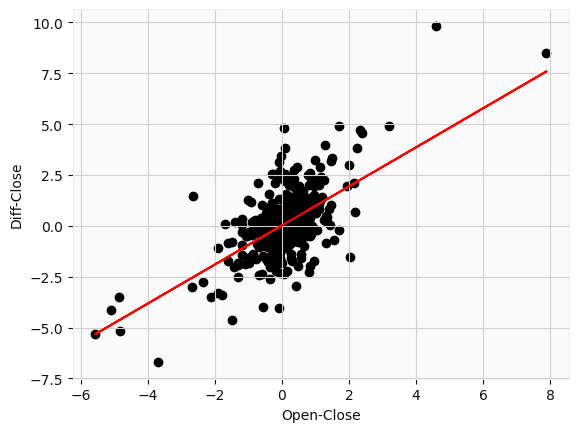

In [139]:
regr = Ridge(alpha=1e-15)
regr.fit(X_train_reg, y_train_reg)

y_pred = regr.predict(X_test_reg)
y_pred_train = regr.predict(X_train_reg)

print(f'R^2 value for test set is {regr.score(X_test_reg,y_test_reg)}')
print(f'Mean squared error is {mean_squared_error(y_test_reg,y_pred)}')


plt.scatter(df_updated['Open-Close'][1:],df_updated['Diff_Close'][1:],c='k')
plt.plot(df_updated['Open-Close'][1:], (regr.coef_[0] * df_updated['Open-Close'][1:] + regr.intercept_), c='r' );
plt.xlabel('Open-Close')
plt.ylabel('Diff-Close')

We obtained a mean square error of 0.58 which is fairly moderate. Our R^2 value basically says 54% of the variance in the
differential close price is explained by the differential open-close price. Not so bad so far. But to be truly effective, we need to make use of statistics. Specifically, let's define a confidence interval around our predictions i.e prediction intervals. 

Prediction intervals give you a range for the prediction that accounts for any threshold of modeling error. Prediction intervals are most commonly used when making predictions or forecasts with a regression model, where a quantity is being predicted. We select the 95% confidence interval in this example such that our actual predictions fall into this range 99% of the time. For an in-depth overview and explanation please explore [machinelearningmastery](https://machinelearningmastery.com/prediction-intervals-for-machine-learning/)

In [184]:
def predict_range(X,y,model,conf=2.58):
    
    from numpy import sum as arraysum
    
    # Obtain predictions
    yhat = model.predict(X)
    
    # Compute standard deviation
    sum_errs = arraysum((y - yhat)**2)
    stdev = np.sqrt(1/(len(y)-2) * sum_errs)
    
    interval = conf * stdev
    
    lower = []
    upper = []
    
    for i in yhat:
        lower.append(i-interval)
        upper.append(i+interval)

    
    return lower, upper, interval

In [185]:
lower, upper, interval = predict_range(X_reg, y_reg,regr)

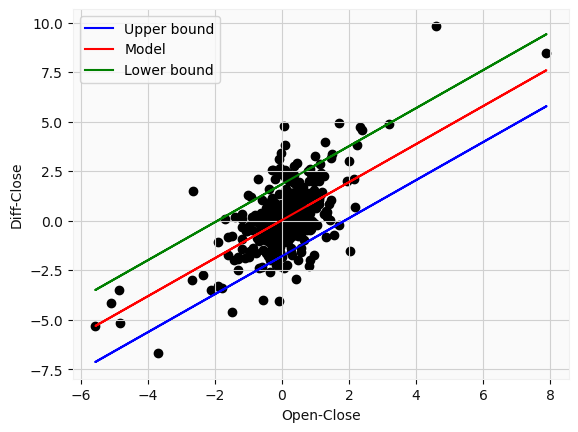

In [190]:
plt.scatter(X_reg ,df_updated['Diff_Close'][1:],c='k')
plt.plot(X_reg , lower, c='b' )
plt.plot(X_reg , (regr.coef_[0] * df_updated['Open-Close'][1:] + regr.intercept_), c='r' )
plt.plot(X_reg , upper, c='g' )
#plt.errorbar(X_reg , (regr.coef_[0] * df_updated['Open-Close'][1:] + regr.intercept_),yerr=interval)
#

plt.xlabel('Open-Close')
plt.ylabel('Diff-Close')
plt.legend(['Upper bound','Model','Lower bound']);

Our prediction error corresponds to a value of **$1.82** in this example. Of course the parameters used to obtain our regression model (slope and intercept) also have confidence interval which we could calculate, but its the same process as highlighted above. From this plot, we can see that even with a 99% confidence interval, some values still fall outside the range. This highlights just how difficult it is forecasting stock price movements. So ideally we would suppliment our analysis with news, technical indicators and other parameters. In addition, our model is still quite limited. We can only make predictions about closing price on the same day i.e at time **t**. Even with the large uncertainty, this could prove useful in, for instance, options tradings. 

## What does it all mean

The stock screening strategy introduced could be a valuable tool for finding good stocks and minimizing loss. Certainly, in future projects, I could perform sentiment analysis myself in order to get information on every stock from the biggest movers list. There is also some room for improvement in the LSTM algorithm. If there was a way to minimize the bias and eliminate the implicit autocorrelation in the results, I’d love to hear about it. So far, the majority of research on the topic haven’t shown how to bypass this issue. Of course, more model tuning and data may help so any experts out there, please give me some feedback. The regression analysis seems pretty basic but could be a good way of adding extra information in our trading decisions. Of course, we could have gone with a more sophisticated approach; the differential prices almost appear to form an ellipse around the origin. Using a radial SVM classifier could also be a potential way of estimating stock movements.